In [1]:
!pip install ultralytics

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ----------------

In [ ]:
from ultralytics import YOLO
#license_ver1.yolov8-obb 란 폴더명은 제가 지었어요
dataset_path = "D://workspace/license_ver1.yolov8-obb"
model = YOLO("yolov8s-seg.pt")  # 사전학습된 yolov8-seg 모델 불러오기
# 전이학습 시작
results = model.train(data=f"{dataset_path}/data.yaml", epochs=50, imgsz=640, batch=16)
# 학습 결과 요약 및 검증
print(results.metrics)
# 또는 모델 검증 함수 별도로 실행
model.val(data=f"{dataset_path}/data.yaml")

Ultralytics 8.3.191  Python-3.13.5 torch-2.8.0+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D://workspace/license_ver1.yolov8-obb/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
import os

# 1) 학습된 모델 불러오기 (로컬 학습 결과 경로에 맞게 변경)
model = YOLO(r'D:\workspace\license_ver1.yolov8-obb\runs\segment\train\weights\best.pt')

# 2) 테스트 이미지가 있는 로컬 폴더 경로 지정 (roboflow 다운로드 구조에 맞게)
# Windows 경로를 raw string(r'경로') 형태로 쓰는 걸 추천
test_images_folder = r'D:\workspace\license_ver1.yolov8-obb\test\images'

# 3) 이미지 파일명 리스트 가져오기 (jpg 등 확장자 맞게)
image_paths = glob.glob(os.path.join(test_images_folder, '*.jpg'))

print(f"총 테스트 이미지 수: {len(image_paths)}")

# 4) 클래스 이름(license_plate, text) 확인
class_names = model.names

# 5) 각 이미지에 대해 예측 수행 & 시각화 함수 정의
def visualize_prediction(img_path):
    # 이미지 읽기
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 예측
    results = model.predict(source=img_path, conf=0.25, save=False)

    for result in results:
        masks = result.masks.data.cpu().numpy() if result.masks else None
        boxes = result.boxes.xyxy.cpu().numpy() if result.boxes else None
        classes = result.boxes.cls.cpu().numpy().astype(int) if result.boxes else None

        if masks is not None and boxes is not None and classes is not None:
            for i in range(len(classes)):
                cls_id = classes[i]
                cls_name = class_names[cls_id]

                # license_plate는 녹색, text는 보라색
                color = (0, 255, 0) if cls_name == 'license_plate' else (128, 0, 128)

                # 바이너리 마스크는 0~1 형태라 255 곱해 uint8 변환 후 컨투어 추출
                mask = masks[i].astype('uint8') * 255  
                contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(img_rgb, contours, -1, color, 2)

                # 바운딩 박스 그리기
                x1, y1, x2, y2 = boxes[i].astype(int)
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)

                # 클래스명 텍스트 표시
                cv2.putText(img_rgb, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # 시각화 - matplotlib 사용
    plt.figure(figsize=(12,8))
    plt.imshow(img_rgb)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()

# 6) 처음 3개 이미지에 대해 예측 및 시각화 (수량 변경 가능)
for img_file in image_paths[:3]:
    visualize_prediction(img_file)

In [ ]:
#============아래는 3번 작업===================

In [1]:
import glob
import os

from ultralytics import YOLO
import cv2

# 모델 경로와 이미지 폴더 경로
model_path = r"D:\workspace\license_ver1.yolov8-obb\yolov8s-seg.pt"
image_folder = r"D:\workspace\license_ver1.yolov8-obb\test\images"
label_folder = r"D:\workspace\license_ver1.yolov8-obb\test\labels"  # 라벨 텍스트 폴더 경로 여기에 맞게 지정

# YOLO 모델 로드
model = YOLO(model_path)

# 1행/2행 판별 함수 정의
def check_text_lines(num_lines):
    if num_lines == 1:
        return "1행 번호판"
    elif num_lines == 2:
        return "2행 번호판"
    else:
        return f"{num_lines}행 번호판 (비정상)"

# 이미지 파일 리스트 가져오기 (jpg, png 등 필요하면 확장자 추가)
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))

for img_path in image_files:
    # 이미지 파일명에서 확장자 제거
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # 대응하는 라벨 파일 경로 (확장자 txt, 라벨 폴더 위치에 맞게 조정)
    label_path = os.path.join(label_folder, base_name + ".txt")

    # 라벨 파일이 있으면 읽기
    if os.path.exists(label_path):
        with open(label_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # 라벨 라인 수 == 텍스트 라인 수
        num_text_lines = len(lines)

        판별결과 = check_text_lines(num_text_lines)

        # 이미지 불러오기 및 YOLO 추론 (필요에 따라)
        img = cv2.imread(img_path)
        result = model(img)

        print(f"{base_name} : {판별결과}, 텍스트 라인 수 = {num_text_lines}")
    else:
        print(f"{base_name} : 라벨 파일이 없음")


0: 640x640 (no detections), 481.7ms
Speed: 8.4ms preprocess, 481.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)
01-0216_jpg.rf.ba2842d5f07660a2de95c7c90e7385f2 : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 (no detections), 348.7ms
Speed: 5.0ms preprocess, 348.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
01-0388_jpg.rf.d7947080ef8aa78cfed231107896628e : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 (no detections), 307.6ms
Speed: 4.5ms preprocess, 307.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
01-0407_jpg.rf.30fd51a6fa95d0e2abc8a6bb515e4bc5 : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 (no detections), 309.8ms
Speed: 4.3ms preprocess, 309.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
01-0425_jpg.rf.31d50e0abd5e7f94c8c25900bfc96c9c : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 (no detections), 311.4ms
Speed: 4.4ms preprocess, 311.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
01-0724-2_jpg.rf.04d4f96b0ade42f3945d0cce

In [3]:
import glob
import os
import cv2
from ultralytics import YOLO

# 경로
model_path = r"D:\workspace\license_ver1.yolov8-obb\best.pt"
image_folder = r"D:\workspace\license_ver1.yolov8-obb\test\images"
label_folder = r"D:\workspace\license_ver1.yolov8-obb\test\labels"  # 라벨 텍스트 폴더 위치
save_folder = r"D:\workspace\save"

os.makedirs(save_folder, exist_ok=True)

# 모델 로드
model = YOLO(model_path)

def check_text_lines(num_lines):
    if num_lines == 1:
        return "1행 번호판"
    elif num_lines == 2:
        return "2행 번호판"
    else:
        return f"{num_lines}행 번호판 (비정상)"

# 이미지 파일 모두 불러오기
image_files = glob.glob(os.path.join(image_folder, "*.jpg"))  # 필요 시 png 등 추가 가능

for img_path in image_files:
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(label_folder, base_name + ".txt")

    # 라벨 파일 읽기 및 텍스트 라인 수 확인
    if os.path.exists(label_path):
        with open(label_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        num_text_lines = len(lines)
        판별결과 = check_text_lines(num_text_lines)
    else:
        판별결과 = "라벨 파일 없음"
        num_text_lines = 0

    img = cv2.imread(img_path)
    if img is None:
        print(f"{base_name} : 이미지 로딩 실패")
        continue

    # YOLO 추론
    results = model(img)

    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        print(f"{base_name} : 탐지된 객체 없음, {판별결과}, 텍스트 라인 수 = {num_text_lines}")
    else:
        for box in boxes:
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = xyxy
            cls = int(box.cls.cpu().numpy()[0])
            conf = float(box.conf.cpu().numpy()[0])

            # 파란색 바운딩 박스 및 텍스트 표시
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label = f"{cls}: {conf:.2f}"
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (255, 0, 0), 2)

        print(f"{base_name} : {판별결과}, 텍스트 라인 수 = {num_text_lines}")

        # 결과 이미지 저장
        save_path = os.path.join(save_folder, base_name + "_result.jpg")
        cv2.imwrite(save_path, img)


0: 640x640 1 license_plate, 1 text, 336.7ms
Speed: 6.4ms preprocess, 336.7ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
01-0216_jpg.rf.ba2842d5f07660a2de95c7c90e7385f2 : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 1 license_plate, 1 text, 301.3ms
Speed: 4.3ms preprocess, 301.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)
01-0388_jpg.rf.d7947080ef8aa78cfed231107896628e : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 1 license_plate, 1 text, 305.6ms
Speed: 4.4ms preprocess, 305.6ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)
01-0407_jpg.rf.30fd51a6fa95d0e2abc8a6bb515e4bc5 : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 1 license_plate, 1 text, 312.5ms
Speed: 4.4ms preprocess, 312.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)
01-0425_jpg.rf.31d50e0abd5e7f94c8c25900bfc96c9c : 2행 번호판, 텍스트 라인 수 = 2

0: 640x640 1 license_plate, 1 text, 308.7ms
Speed: 4.3ms preprocess, 308.7ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)
0

In [16]:
import os
import glob
import cv2
from ultralytics import YOLO

# 경로 설정
model_path = r"D:\workspace\license_ver1.yolov8-obb\best.pt"
image_folder = r"D:\workspace\license_ver1.yolov8-obb\test\images"
label_folder = r"D:\workspace\license_ver1.yolov8-obb\test\labels"
save_root = r"D:\workspace\splitsave"

# 클래스 번호별 폴더명 (best.pt 학습 체계에 맞게 설정)
class_to_folder = {
    0: "plate",
    1: "s1",  # 단일 행 텍스트 (1행)
    2: "d1",  # 2행 위쪽
    3: "d2"   # 2행 아래쪽
}

# 저장 폴더가 없으면 생성
for folder in class_to_folder.values():
    os.makedirs(os.path.join(save_root, folder), exist_ok=True)

# 라벨 파일에서 클래스 1 개수 확인 함수
def count_class_1(label_path):
    count = 0
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 1 and int(parts[0]) == 1:
                count += 1
    return count

# 모델 로드
model = YOLO(model_path)

# 이미지 파일 리스트 조회
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

for img_path in image_paths:
    img_name = os.path.splitext(os.path.basename(img_path))[0]

    label_path = os.path.join(label_folder, img_name + ".txt")
    if not os.path.exists(label_path):
        print(f"[경고] 라벨 없음: {img_name}")
        continue

    # 클래스 1 개수 미리 파악
    class1_count = count_class_1(label_path)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[경고] 이미지 로드 실패: {img_name}")
        continue

    results = model(img)
    boxes = results[0].boxes

    if boxes is None or len(boxes) == 0:
        print(f"[정보] {img_name} - 탐지 객체 없음")
        continue

    count_per_class = {}

    # 클래스 1이 2개라면 d1, d2 분리 필요. 그 외에는 s1 처리
    # boxes 내 클래스 번호, bbox 좌표 사용
    cls1_boxes = []
    # 우선 클래스 0, 1, 2, 3 분리하여 별도 저장용 리스트로 분류
    for box in boxes:
        cls = int(box.cls.cpu().numpy()[0])
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        if cls == 0:
            # plate 처리
            x1, y1, x2, y2 = xyxy
            crop_img = img[y1:y2, x1:x2]
            folder = class_to_folder[0]
            count_per_class[0] = count_per_class.get(0, 0) + 1
            idx = count_per_class[0]
            save_name = f"{img_name}_plate_{idx}.jpg" if idx > 1 else f"{img_name}_plate.jpg"
            cv2.imwrite(os.path.join(save_root, folder, save_name), crop_img)

        elif cls == 1:
            cls1_boxes.append((xyxy, box))

        else:
            # 클래스 2, 3가 미리 탐지되는 상황이 있으면 바로 저장
            folder = class_to_folder.get(cls)
            if folder:
                x1, y1, x2, y2 = xyxy
                crop_img = img[y1:y2, x1:x2]
                count_per_class[cls] = count_per_class.get(cls, 0) + 1
                idx = count_per_class[cls]
                save_name = f"{img_name}_{folder}_{idx}.jpg" if idx > 1 else f"{img_name}_{folder}.jpg"
                cv2.imwrite(os.path.join(save_root, folder, save_name), crop_img)

    # 이제 클래스1 박스 처리
    if class1_count == 1:
        # 하나면 s1 폴더에 저장
        xyxy, box = cls1_boxes[0]
        x1, y1, x2, y2 = xyxy
        crop_img = img[y1:y2, x1:x2]
        folder = class_to_folder[1]
        count_per_class[1] = count_per_class.get(1, 0) + 1
        idx = count_per_class[1]
        save_name = f"{img_name}_s1_{idx}.jpg" if idx > 1 else f"{img_name}_s1.jpg"
        cv2.imwrite(os.path.join(save_root, folder, save_name), crop_img)

    elif class1_count == 2:
        # 두 개면 y 좌표로 오름차순 정렬 후 d1(위), d2(아래) 분리 저장
        sorted_cls1 = sorted(cls1_boxes, key=lambda b: b[0][1])  # y1 좌표
        for idx, (xyxy, box) in enumerate(sorted_cls1, start=1):
            x1, y1, x2, y2 = xyxy
            crop_img = img[y1:y2, x1:x2]
            folder = class_to_folder[1 + idx]  # 2->d1, 3->d2로 매칭됨
            count_per_class[1 + idx] = count_per_class.get(1 + idx, 0) + 1
            count_idx = count_per_class[1 + idx]
            suffix = f"d{idx}"
            save_name = f"{img_name}_{suffix}_{count_idx}.jpg" if count_idx > 1 else f"{img_name}_{suffix}.jpg"
            cv2.imwrite(os.path.join(save_root, folder, save_name), crop_img)

    else:
        print(f"[경고] {img_name} - 클래스1 개수 이상: {class1_count}")

    print(f"{img_name} 처리 완료")

print("전체 작업 완료!")


0: 640x640 1 license_plate, 1 text, 322.9ms
Speed: 6.4ms preprocess, 322.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)
01-0216_jpg.rf.ba2842d5f07660a2de95c7c90e7385f2 처리 완료

0: 640x640 1 license_plate, 1 text, 309.8ms
Speed: 5.7ms preprocess, 309.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)
01-0388_jpg.rf.d7947080ef8aa78cfed231107896628e 처리 완료

0: 640x640 1 license_plate, 1 text, 331.8ms
Speed: 4.9ms preprocess, 331.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)
01-0407_jpg.rf.30fd51a6fa95d0e2abc8a6bb515e4bc5 처리 완료

0: 640x640 1 license_plate, 1 text, 318.4ms
Speed: 6.2ms preprocess, 318.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)
01-0425_jpg.rf.31d50e0abd5e7f94c8c25900bfc96c9c 처리 완료

0: 640x640 1 license_plate, 1 text, 321.9ms
Speed: 4.9ms preprocess, 321.9ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)
01-0724-2_jpg.rf.04d4f96b0ade42f3945d0ccef44b1a8f 처리 완료

0: 640x640 1

In [ ]:
#=====우선 위 코드가 성공하여 splitsave에 s1,d1,d2,plate 로 구분하여 이미지 저장하며
#아래는 koreansave 에 이름까지 변경한 코드

In [19]:
import os
import shutil
import glob
import re

# 경로 설정
sampleimg_folder = r"D:\workspace\sampleimg"
splitsave_root = r"D:\workspace\splitsave"
koreansave_root = r"D:\workspace\koreansave"

# 클래스별 폴더명
class_folders = ["plate", "s1", "d1", "d2"]

# koreansave 내 클래스별 폴더 생성
for folder in class_folders:
    os.makedirs(os.path.join(koreansave_root, folder), exist_ok=True)

def normalize_name(name):
    """
    이름에서 첫 번째와 두 번째 숫자 그룹만 추출해 조합
    예: "01가0785" -> "010785"
    예: "01-0216_jpg.rf.ba2842d5f..." -> "010216"
    """
    # 숫자 그룹 추출
    number_groups = re.findall(r'\d+', name)
    
    # 첫 번째와 두 번째 숫자 그룹만 사용 (있는 경우)
    if len(number_groups) >= 2:
        return number_groups[0] + number_groups[1]
    elif len(number_groups) == 1:
        return number_groups[0]
    else:
        return ""

# sampleimg 파일 처리
sampleimg_files = glob.glob(os.path.join(sampleimg_folder, "*.jpg"))
sampleimg_map = {}
for path in sampleimg_files:
    base = os.path.splitext(os.path.basename(path))[0]
    norm = normalize_name(base)
    sampleimg_map[norm] = base + ".jpg"

print(f"샘플 이미지 매핑 {len(sampleimg_map)}개 생성 완료")

# splitsave 각 클래스 폴더 처리
match_count = 0
for cls_folder in class_folders:
    split_folder_path = os.path.join(splitsave_root, cls_folder)
    if not os.path.exists(split_folder_path):
        print(f"[주의] 폴더 없음: {split_folder_path}")
        continue
        
    split_files = glob.glob(os.path.join(split_folder_path, "*.jpg"))

    for split_file in split_files:
        base_split = os.path.splitext(os.path.basename(split_file))[0]
        norm_split = normalize_name(base_split)

        if norm_split in sampleimg_map:
            korean_name = sampleimg_map[norm_split]
            src = split_file
            dst = os.path.join(koreansave_root, cls_folder, korean_name)
            shutil.copy2(src, dst)
            print(f"{base_split} → {cls_folder}/{korean_name} 복사 완료")
            match_count += 1
        else:
            print(f"[경고] 매칭 실패: {base_split} (정규화: {norm_split})")

print(f"모든 복사 작업 완료! 총 {match_count}개 파일 매칭 성공")

샘플 이미지 매핑 321개 생성 완료
01-0216_jpg.rf.ba2842d5f07660a2de95c7c90e7385f2_plate → plate/01소0216.jpg 복사 완료
01-0388_jpg.rf.d7947080ef8aa78cfed231107896628e_plate → plate/01저0388.jpg 복사 완료
01-0407_jpg.rf.30fd51a6fa95d0e2abc8a6bb515e4bc5_plate → plate/01주0407.jpg 복사 완료
01-0425_jpg.rf.31d50e0abd5e7f94c8c25900bfc96c9c_plate → plate/01누0425.jpg 복사 완료
01-0724-2_jpg.rf.04d4f96b0ade42f3945d0ccef44b1a8f_plate → plate/01호0724.jpg 복사 완료
01-0787_jpg.rf.16fb615457052cf0ce038186f6c7eb5a_plate → plate/01무0787.jpg 복사 완료
01-1316-2_jpg.rf.74a58545d67118d93a5d6d870345ed77_plate → plate/01두1316.jpg 복사 완료
01-1316-3_jpg.rf.e0abcd5712b982f8489c0c34939d1c7a_plate → plate/01두1316.jpg 복사 완료
01-1366_jpg.rf.8b920ec024720f59d25193229c1326f9_plate → plate/01가1366.jpg 복사 완료
01-1607-2_jpg.rf.295dfabca5b46f6b7ed4917edfa848e0_plate → plate/01부1607.jpg 복사 완료
01-1607_jpg.rf.d4076104661a639b730e2f2244847bea_plate → plate/01부1607.jpg 복사 완료
01-1705_jpg.rf.f5da065c06b23c18ceeddd3abc9c2c49_plate → plate/01가1705.jpg 복사 완료
01-1864-2_j

In [ ]:
#===위코드 성공하여 koreansave에 폴더별로 이름변경된 이미지 나옴

In [1]:
import os

koreansave_root = r"D:\workspace\koreansave"
class_folders = ["plate", "s1", "d1", "d2"]
suffix_map = {
    "plate": "_plate",
    "s1": "_s1",
    "d1": "_d1",
    "d2": "_d2",
}

for folder in class_folders:
    folder_path = os.path.join(koreansave_root, folder)
    if not os.path.isdir(folder_path):
        print(f"[경고] 폴더 없음: {folder_path}")
        continue

    for filename in os.listdir(folder_path):
        base, ext = os.path.splitext(filename)
        suffix = suffix_map[folder]

        # 이미 변경된 이름인지 체크 (중복방지)
        if not base.endswith(suffix):
            new_name = base + suffix + ext
            src = os.path.join(folder_path, filename)
            dst = os.path.join(folder_path, new_name)

            # 이름 중복 방지
            if os.path.exists(dst):
                print(f"[경고] 변경하려는 이름이 이미 존재합니다: {dst}")
            else:
                os.rename(src, dst)
                print(f"{filename} → {new_name} 이름 변경 완료")

print("모든 폴더 이름 변경 작업 완료")

01가1366.jpg → 01가1366_plate.jpg 이름 변경 완료
01가1705.jpg → 01가1705_plate.jpg 이름 변경 완료
01가2319.jpg → 01가2319_plate.jpg 이름 변경 완료
01가2636.jpg → 01가2636_plate.jpg 이름 변경 완료
01가3372.jpg → 01가3372_plate.jpg 이름 변경 완료
01가3435.jpg → 01가3435_plate.jpg 이름 변경 완료
01고2206.jpg → 01고2206_plate.jpg 이름 변경 완료
01고7060.jpg → 01고7060_plate.jpg 이름 변경 완료
01고7640.jpg → 01고7640_plate.jpg 이름 변경 완료
01고8469.jpg → 01고8469_plate.jpg 이름 변경 완료
01구2126.jpg → 01구2126_plate.jpg 이름 변경 완료
01구5501.jpg → 01구5501_plate.jpg 이름 변경 완료
01구7573.jpg → 01구7573_plate.jpg 이름 변경 완료
01구7970.jpg → 01구7970_plate.jpg 이름 변경 완료
01누0425.jpg → 01누0425_plate.jpg 이름 변경 완료
01누3534.jpg → 01누3534_plate.jpg 이름 변경 완료
01누5728.jpg → 01누5728_plate.jpg 이름 변경 완료
01누6129.jpg → 01누6129_plate.jpg 이름 변경 완료
01더3774.jpg → 01더3774_plate.jpg 이름 변경 완료
01더5687.jpg → 01더5687_plate.jpg 이름 변경 완료
01두1316.jpg → 01두1316_plate.jpg 이름 변경 완료
01두1879.jpg → 01두1879_plate.jpg 이름 변경 완료
01라8536.jpg → 01라8536_plate.jpg 이름 변경 완료
01러2710.jpg → 01러2710_plate.jpg 이름 변경 완료
01로3072.jpg → 01

In [10]:
import os
import csv
import re

koreansave_root = r"D:\workspace\koreansave"
class_folders = ["plate", "s1", "d1", "d2"]

def extract_label_from_filename(filename):
    """
    파일명에서 '_plate', '_s1', '_d1', '_d2' 이전 부분만 추출 (확장자 제외)
    예: '01가1366_plate.jpg' -> '01가1366'
        '01고7640_d1.jpg' -> '01고7640'
    """
    name_without_ext = os.path.splitext(filename)[0]
    # _plate, _s1, _d1, _d2 접미사 기준으로 split
    label = re.split(r'_(?:plate|s1|d1|d2)$', name_without_ext)
    return label[0]  # 리스트 첫번째 요소 반환

csv_save_path = r"D:\workspace\labels.csv"

with open(csv_save_path, mode='w', newline='', encoding='utf-8-sig') as f:
    writer = csv.writer(f)
    writer.writerow(["image_path", "label"])

    for folder in class_folders:
        folder_path = os.path.join(koreansave_root, folder)
        if not os.path.isdir(folder_path):
            print(f"[주의] 폴더가 존재하지 않음: {folder_path}")
            continue

        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpg", ".png")):
                image_path = os.path.join(folder_path, filename)
                label = extract_label_from_filename(filename)

                writer.writerow([image_path, label])

print(f"labels.csv 파일 생성 완료: {csv_save_path}")

labels.csv 파일 생성 완료: D:\workspace\labels.csv


In [ ]:
#=============

In [9]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import re
from tqdm.auto import tqdm # tqdm.auto를 사용하면 Jupyter/Colab 환경에서 더 잘 작동해요

# 경로 설정
csv_path = r"D:\workspace\labels.csv"
output_dir = r"D:\workspace\model_output"
os.makedirs(output_dir, exist_ok=True)

# 1. 데이터셋 준비
class LicensePlateDataset(Dataset):
    def __init__(self, data_df, transform=None, max_label_length=10):
        self.data = data_df
        self.transform = transform
        self.max_label_length = max_label_length
        
        # 문자 집합 생성 (한글, 숫자 포함)
        # 네 번호판 데이터에 맞게 필요시 'ㄱㄴㄷ...' 혹은 특수 문자 추가 가능
        self.chars = "가나다라마바사아자차카타파하거너더러머버서어저처커터퍼허고노도로모보소오조초코토포호구누두루무부수우주추쿠투푸후0123456789"
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.chars)}  # 0은 blank로 예약
        self.idx_to_char = {idx + 1: char for idx, char in enumerate(self.chars)}
        self.idx_to_char[0] = ''  # blank 문자 (CTC의 핵심)
        self.num_classes = len(self.chars) + 1  # blank 포함
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label_text = str(self.data.iloc[idx, 1]) # 혹시 라벨이 숫자로 되어있을까봐 str로 변환
        
        # 이미지 로드 및 전처리
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            else: # transform이 없어도 기본적으로 텐서로 변환
                image = transforms.ToTensor()(image) 
        except Exception as e:
            print(f"이미지 로드 오류 또는 변환 실패 {img_path}: {e}. 검은색 이미지로 대체합니다.")
            # 오류 발생 시 검은 이미지 생성 (CNN input shape에 맞게)
            # transform에 설정된 사이즈 (64, 200) 에 맞춰 임의로 생성
            image = torch.zeros((3, 64, 200), dtype=torch.float32) 
            
        # 라벨 전처리 - 문자를 인덱스로 변환
        label_indices = [self.char_to_idx.get(c, 0) for c in label_text] # char_to_idx에 없는 문자는 blank(0)으로 처리
        
        label_length = len(label_indices)
        
        # 패딩 추가
        if label_length > self.max_label_length: # 라벨이 너무 길면 자르기
            label_indices = label_indices[:self.max_label_length]
            label_length = self.max_label_length
        else: # 라벨이 짧으면 패딩
            label_indices = label_indices + [0] * (self.max_label_length - label_length)
            
        return image, torch.tensor(label_indices, dtype=torch.long), torch.tensor(label_length, dtype=torch.long)

# 2. CTC 모델 정의
class CTCModel(nn.Module):
    def __init__(self, num_classes):
        super(CTCModel, self).__init__()
        
        # CNN 특징 추출기: 입력 이미지 (3, H, W)
        # 목표: 시퀀스 (N, W_seq, C_feat) 형태의 특징 벡터를 뽑는 것
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (32, H/2, W/2)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (64, H/4, W/4)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (128, H/8, W/8)
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 이미지 높이가 작아질수록 MaxPoold의 kernel을 1로 설정하여 폭만 줄이도록
            nn.MaxPool2d((2, 1), (2, 1)),  # Output: (256, H/16, W/8) - H가 64면 H/16은 4
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), # 배치 정규화 추가
            nn.ReLU()
        )
        
        # RNN 시퀀스 처리
        # CNN에서 나온 특징맵의 높이(H_feat) * 채널(C_feat)이 RNN의 입력 차원
        # W (너비) 방향으로 시퀀스를 처리
        self.rnn = nn.LSTM(input_size=512 * 4, hidden_size=256, 
                           num_layers=2, bidirectional=True, batch_first=True) # num_layers 추가
        
        # 최종 출력 레이어 (양방향 RNN이라 256*2 = 512)
        self.fc = nn.Linear(512, num_classes) # num_classes는 blank 포함된 문자 개수
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN 특징 추출
        cnn_features = self.cnn(x) # 예: (N, 512, 4, 25) for 64x200 input
        
        # RNN 입력을 위한 reshape
        # [batch, channels, height, width] -> [batch, width, channels * height]
        # 즉, 높이와 채널을 합쳐 하나의 "특징"으로 만들고 너비 방향으로 시퀀스
        cnn_features = cnn_features.permute(0, 3, 1, 2) # (N, W, C, H) 예: (N, 25, 512, 4)
        
        # RNN의 input_size에 맞게 Flatten
        cnn_features = cnn_features.reshape(batch_size, cnn_features.size(1), -1) # (N, W, C*H) 예: (N, 25, 512*4)
        
        # RNN 처리
        rnn_outputs, _ = self.rnn(cnn_features) # rnn_outputs: (N, W, hidden_size*2)
        
        # 최종 출력 (LogSoftmax 포함되어있으므로 CrossEntropyLoss 대신 CTCLoss 사용)
        output = self.fc(rnn_outputs) # (N, W, num_classes)
        output = nn.functional.log_softmax(output, dim=2)
        
        return output

# 3. 예측 디코딩 함수 (CTC -> 텍스트)
def decode_ctc_prediction(pred_seq, dataset_obj):
    # argmax를 사용하여 각 시퀀스 스텝에서 가장 높은 확률의 문자 선택
    greedy_decoded = torch.argmax(pred_seq, dim=-1).squeeze()
    
    # CTC 디코딩 규칙 적용: blank (0) 제거 및 중복 문자 제거
    result = []
    prev_char_idx = -1 # 이전 문자가 blank 인지 아닌지
    
    for char_idx in greedy_decoded:
        char_idx_item = char_idx.item()
        if char_idx_item != 0 and char_idx_item != prev_char_idx:
            result.append(dataset_obj.idx_to_char[char_idx_item])
        prev_char_idx = char_idx_item
            
    return ''.join(result)

# 4. 문자 오류율 (CER) 계산 함수
def calculate_cer(reference, hypothesis):
    # Reference: 실제 라벨 (정답)
    # Hypothesis: 모델 예측 (결과)
    # Levenshtein distance (편집 거리)를 사용하여 CER 계산
    
    # 이 부분은 외부 라이브러리 `python-Levenshtein`나 `editdistance`가 더 정확하지만,
    # 여기서는 간단한 버전으로 구현하거나, 편의를 위해 라이브러리 사용을 권장.
    # 일단은 비교 목적으로만 사용 (정식 평가는 라이브러리 추천)
    
    len_ref = len(reference)
    len_hyp = len(hypothesis)
    
    # 단순화된 CER (정확한 CER 계산은 좀 더 복잡)
    # 여기서는 단순히 일치하는 문자의 비율로 계산합니다.
    # 정확한 편집 거리 기반 CER 계산은 'Levenshtein' 또는 'editdistance' 라이브러리 권장
    
    if len_ref == 0:
        return 1.0 if len_hyp > 0 else 0.0 # 참조가 없는데 예측이 있으면 100% 오류
    
    # 간단하게 Levenshtein distance의 근사치를 사용 (수정, 삽입, 삭제 횟수)
    # 아래는 단순한 정확도이므로 CER과는 다름. 실제 CER 계산 라이브러리 설치 권장
    
    # from Levenshtein import distance
    # if len_ref > 0:
    #     return distance(reference, hypothesis) / len_ref
    # else:
    #     return 0.0 if len_hyp == 0 else 1.0

    # 여기서는 우선 동일한지 여부만으로 "정확도"를 계산 (엄밀한 CER은 아님)
    if reference == hypothesis:
        return 0.0
    else:
        # 이 부분에 Levenshtein distance 계산 로직이나 라이브러리 호출
        # 편의상 일치하지 않으면 일단 오류로 간주
        return 1.0 
    
    # 실제 프로젝트에서는 'editdistance' 라이브러리를 pip install 하고 아래처럼 사용
    # import editdistance
    # return editdistance.eval(reference, hypothesis) / max(len(reference), 1)

# 5. 학습 및 평가 함수
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, 
                       num_epochs, dataset_obj, save_best=True):
    best_val_loss = float('inf')
    
    print("\n--- 학습 시작 ---")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels, label_lengths in train_bar:
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device) # label_lengths도 device로 보내기
            
            optimizer.zero_grad()
            outputs = model(images) # (N, W, num_classes)
            
            # outputs의 시퀀스 길이는 outputs.size(1) (W)
            # labels의 길이는 labels_length
            
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long, device=device) # input_lengths도 device로 보내기
            
            # CTCLoss의 인자 순서: log_probs, targets, input_lengths, target_lengths
            # log_probs는 (T, N, C) 형태로 (시퀀스 길이, 배치 크기, 클래스 개수)
            # 그래서 outputs.permute(1, 0, 2)
            loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        # 검증 단계
        model.eval()
        total_val_loss = 0
        total_cer = 0
        total_samples_for_cer = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, labels, label_lengths in val_bar:
                images = images.to(device)
                labels = labels.to(device)
                label_lengths = label_lengths.to(device) # label_lengths도 device로 보내기
                
                outputs = model(images)
                input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long, device=device)
                
                loss = criterion(outputs.permute(1, 0, 2), labels, input_lengths, label_lengths)
                total_val_loss += loss.item()
                
                # 예측 디코딩 및 CER 계산
                for i in range(outputs.size(0)):
                    # 하나의 예측 시퀀스: outputs[i]
                    predicted_text = decode_ctc_prediction(outputs[i], dataset_obj)
                    
                    # 실제 라벨 텍스트: labels[i]를 다시 문자로 디코딩
                    target_indices = labels[i][:label_lengths[i]].cpu().numpy() # 실제 길이만큼만 가져오기
                    true_text = ''.join([dataset_obj.idx_to_char[idx] for idx in target_indices if idx != 0])
                    
                    if true_text: # 라벨 텍스트가 비어있지 않은 경우에만 CER 계산
                        total_cer += calculate_cer(true_text, predicted_text)
                        total_samples_for_cer += 1
                        
                val_bar.set_postfix(loss=loss.item())

        avg_val_loss = total_val_loss / len(val_loader)
        avg_cer = total_cer / total_samples_for_cer if total_samples_for_cer > 0 else 1.0 # 0으로 나누는 것 방지

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val CER: {avg_cer:.4f}")

        # 모델 저장
        if save_best and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_save_path = os.path.join(output_dir, f'best_model_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f"-> 모델 저장됨: {model_save_path} (Val Loss: {best_val_loss:.4f})")
    print("--- 학습 종료 ---")

# 6. 메인 실행 함수
if __name__ == "__main__":
    # 데이터 로드
    df = pd.read_csv(csv_path)

    # 데이터 분할 (학습:검증)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) # 20%는 검증용으로

    # 이미지 전처리 파이프라인
    transform = transforms.Compose([
        transforms.Resize((64, 200)), # CTC 모델의 CNN 입력 크기에 맞게 조절
        transforms.ToTensor(), # PIL Image를 PyTorch Tensor로 변환 (0~1 스케일)
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 정규화 (선택 사항, ImageNet 표준)
    ])

    # 데이터셋 및 데이터 로더 생성
    # dataset_obj는 문자 인코딩/디코딩을 위해 따로 전달
    train_dataset = LicensePlateDataset(train_df, transform=transform)
    val_dataset = LicensePlateDataset(val_df, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0) # num_workers는 필요에 따라 조절 (데이터 로드 속도)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # 디바이스 설정 (GPU 사용 가능하면 GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"사용 디바이스: {device}")

    # 모델 초기화
    # train_dataset.num_classes를 사용하여 blank를 포함한 총 클래스 개수를 전달
    model = CTCModel(num_classes=train_dataset.num_classes).to(device)

    # CTC 손실 함수 (blank index는 기본 0)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True).to(device)

    # 옵티마이저
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 학습 및 평가 실행
    num_epochs = 20 # 에포크 수 (일단 낮게 시작, 데이터 양에 따라 조절)
    train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, train_dataset, save_best=True)

    print("CTC 모델 학습 및 검증 과정 완료!")
    print(f"최고 성능 모델은 {output_dir} 폴더에 저장되었어요!")

사용 디바이스: cpu

--- 학습 시작 ---


Epoch 1/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 13.1358, Val Loss: 12.6724, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_1.pth (Val Loss: 12.6724)


Epoch 2/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 5.2457, Val Loss: 6.1703, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_2.pth (Val Loss: 6.1703)


Epoch 3/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 4.0718, Val Loss: 3.6618, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_3.pth (Val Loss: 3.6618)


Epoch 4/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 3.6826, Val Loss: 3.2612, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_4.pth (Val Loss: 3.2612)


Epoch 5/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 3.1676, Val Loss: 3.2121, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_5.pth (Val Loss: 3.2121)


Epoch 6/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 3.2396, Val Loss: 3.3006, Val CER: 1.0000


Epoch 7/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 3.2706, Val Loss: 3.1762, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_7.pth (Val Loss: 3.1762)


Epoch 8/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 3.1015, Val Loss: 3.1298, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_8.pth (Val Loss: 3.1298)


Epoch 9/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 3.0402, Val Loss: 3.1846, Val CER: 1.0000


Epoch 10/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 3.0793, Val Loss: 3.1981, Val CER: 1.0000


Epoch 11/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 3.0791, Val Loss: 3.1374, Val CER: 1.0000


Epoch 12/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 3.0294, Val Loss: 3.0586, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_12.pth (Val Loss: 3.0586)


Epoch 13/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 2.9834, Val Loss: 3.0223, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_13.pth (Val Loss: 3.0223)


Epoch 14/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 2.9694, Val Loss: 3.0106, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_14.pth (Val Loss: 3.0106)


Epoch 15/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 2.9707, Val Loss: 2.9992, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_15.pth (Val Loss: 2.9992)


Epoch 16/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 2.9562, Val Loss: 2.9846, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_16.pth (Val Loss: 2.9846)


Epoch 17/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 2.9197, Val Loss: 2.9857, Val CER: 1.0000


Epoch 18/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 2.9087, Val Loss: 3.0006, Val CER: 1.0000


Epoch 19/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 2.8935, Val Loss: 2.9853, Val CER: 1.0000


Epoch 20/20 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 2.8763, Val Loss: 2.9470, Val CER: 1.0000
-> 모델 저장됨: D:\workspace\model_output\best_model_epoch_20.pth (Val Loss: 2.9470)
--- 학습 종료 ---
CTC 모델 학습 및 검증 과정 완료!
최고 성능 모델은 D:\workspace\model_output 폴더에 저장되었어요!


In [ ]:
#========pth를 위 코드 통해 생성했고 아래는 그걸 가지고 번호판 텍스트 인식

사용 디바이스: cpu

[plate 폴더 이미지 추론 시작]
01가1366_plate.jpg → 인식 결과: 


C:\Users\602-07\AppData\Local\Temp\ipykernel_9964\1903765450.py:130: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\602-07\AppData\Local\Temp\ipykernel_9964\1903765450.py:130: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\602-07\AppData\Local\Temp\ipykernel_9964\1903765450.py:130: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\602-07\AppData\Local\Temp\ipykernel_9964\1903765450.py:130: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\602-07\AppData\Local\Temp\ipykernel_9964\1903765450.py:130: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\602-07\AppData\Local\Temp\ipykernel_9964\1903765450.py:130: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missin

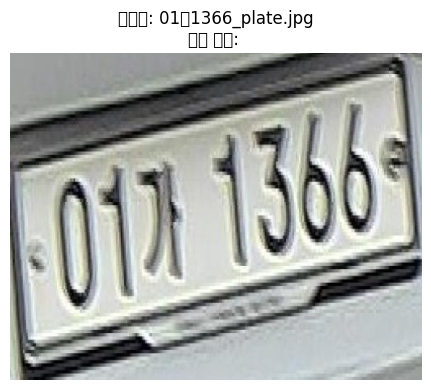

01가1705_plate.jpg → 인식 결과: 


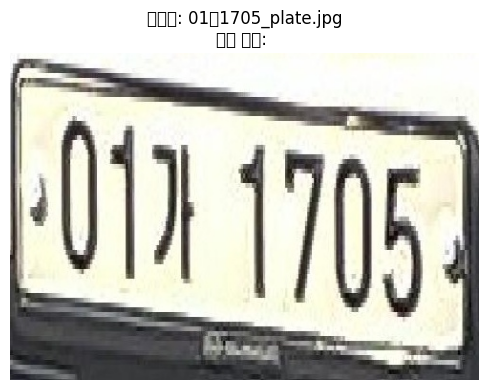

01가2319_plate.jpg → 인식 결과: 


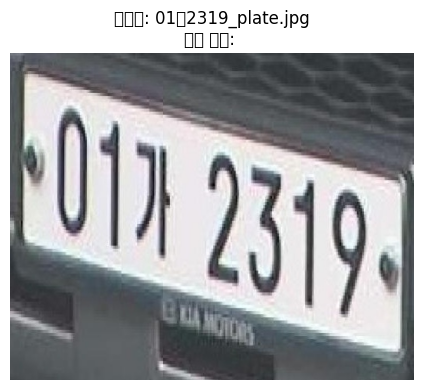

01가2636_plate.jpg → 인식 결과: 
01가3372_plate.jpg → 인식 결과: 

[s1 폴더 이미지 추론 시작]
01가1366_s1.jpg → 인식 결과: 
01가1705_s1.jpg → 인식 결과: 
01가2319_s1.jpg → 인식 결과: 
01가2636_s1.jpg → 인식 결과: 
01가3372_s1.jpg → 인식 결과: 

[d1 폴더 이미지 추론 시작]
01고7640_d1.jpg → 인식 결과: 
01고8469_d1.jpg → 인식 결과: 
01구7573_d1.jpg → 인식 결과: 
01누6129_d1.jpg → 인식 결과: 
01소6665_d1.jpg → 인식 결과: 

[d2 폴더 이미지 추론 시작]
01고7640_d2.jpg → 인식 결과: 
01고8469_d2.jpg → 인식 결과: 
01구7573_d2.jpg → 인식 결과: 
01누6129_d2.jpg → 인식 결과: 
01소6665_d2.jpg → 인식 결과: 

추론 완료! 결과 요약:
01가1366_plate.jpg → 
01가1705_plate.jpg → 
01가2319_plate.jpg → 
01가2636_plate.jpg → 
01가3372_plate.jpg → 
01가1366_s1.jpg → 
01가1705_s1.jpg → 
01가2319_s1.jpg → 
01가2636_s1.jpg → 
01가3372_s1.jpg → 


In [10]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 원본 모델 클래스 정의 (저장했던 것과 동일하게)
class CTCModel(nn.Module):
    def __init__(self, num_classes):
        super(CTCModel, self).__init__()
        
        # CNN 특징 추출기
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # RNN 시퀀스 처리
        self.rnn = nn.LSTM(input_size=512 * 4, hidden_size=256, 
                          num_layers=2, bidirectional=True, batch_first=True)
        
        # 최종 출력 레이어
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN 특징 추출
        cnn_features = self.cnn(x)
        
        # RNN 입력을 위한 reshape
        cnn_features = cnn_features.permute(0, 3, 1, 2)
        cnn_features = cnn_features.reshape(batch_size, cnn_features.size(1), -1)
        
        # RNN 처리
        rnn_outputs, _ = self.rnn(cnn_features)
        
        # 최종 출력
        output = self.fc(rnn_outputs)
        output = nn.functional.log_softmax(output, dim=2)
        
        return output

# 디코딩 함수
def decode_ctc_prediction(pred_seq, idx_to_char):
    pred_indices = torch.argmax(pred_seq, dim=1).cpu().numpy()
    result = []
    prev = -1
    for idx in pred_indices:
        if idx != 0 and idx != prev:  # 0은 blank, 연속된 같은 문자는 하나로 처리
            result.append(idx_to_char.get(idx, ''))
        prev = idx
    return ''.join(result)

# 주요 설정
model_weights_path = r'D:\workspace\model_output\best_model_epoch_20.pth'
image_root = r'D:\workspace\koreansave'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

# 문자 집합 정의 (학습할 때와 동일하게)
chars = "가나다라마바사아자차카타파하거너더러머버서어저처커터퍼허고노도로모보소오조초코토포호구누두루무부수우주추쿠투푸후0123456789"
char_to_idx = {char: idx + 1 for idx, char in enumerate(chars)}
idx_to_char = {idx + 1: char for idx, char in enumerate(chars)}
idx_to_char[0] = ''  # blank 문자

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((64, 200)),
    transforms.ToTensor()
])

# 모델 초기화 및 가중치 로드
num_classes = len(chars) + 1  # blank 포함
model = CTCModel(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.eval()

# 폴더 내 이미지를 돌면서 추론 및 시각화
results = []

for cls in ['plate', 's1', 'd1', 'd2']:
    folder_path = os.path.join(image_root, cls)
    if not os.path.exists(folder_path):
        print(f"폴더가 존재하지 않음: {folder_path}")
        continue

    print(f"\n[{cls} 폴더 이미지 추론 시작]")
    for img_name in os.listdir(folder_path)[:5]:  # 각 폴더당 5개 이미지만 테스트
        if not img_name.lower().endswith(('.jpg', '.png')):
            continue
        
        img_path = os.path.join(folder_path, img_name)
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가
        
        with torch.no_grad():
            output = model(img_tensor)  # (batch, seq_len, num_classes)
        
        # 디코딩하여 텍스트 추출
        pred_text = decode_ctc_prediction(output[0], idx_to_char)
        
        print(f"{img_name} → 인식 결과: {pred_text}")
        results.append((img_path, pred_text))

        # 결과 시각화 (선택 사항)
        if len(results) <= 3:  # 처음 3개 결과만 시각화
            plt.figure(figsize=(10, 4))
            plt.imshow(image)
            plt.title(f"파일명: {img_name}\n인식 결과: {pred_text}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

print("\n추론 완료! 결과 요약:")
for path, text in results[:10]:  # 처음 10개 결과만 출력
    print(f"{os.path.basename(path)} → {text}")

In [6]:
import pandas as pd
import os
import re

# labels.csv 경로
csv_path = r"D:\workspace\labels.csv"
df = pd.read_csv(csv_path)

def process_label(row):
    path = row['image_path']
    label = str(row['label'])
    folder = os.path.basename(os.path.dirname(path))  # 이미지 경로에서 폴더명 추출

    if folder in ['plate', 's1']:
        # plate, s1은 라벨 그대로 유지
        return label
    elif folder == 'd1':
        # d1: 번호판 앞부분 (숫자+한글 등 앞쪽)
        # 예: '01고7640' -> '01고' 추출
        m = re.match(r"([0-9]{2}[가-힣])", label)
        if m:
            return m.group(1)
        else:
            # 정규식 안맞으면 기본값 그대로
            return label
    elif folder == 'd2':
        # d2: 번호판 뒷부분 (숫자만 뽑기)
        # 예: '01고7640' -> '7640' 추출
        m = re.search(r"(\d+)$", label)
        if m:
            return m.group(1)
        else:
            return label
    else:
        # 기타 폴더는 그냥 그대로
        return label

# 라벨 컬럼을 처리 함수 적용하여 수정
df['label'] = df.apply(process_label, axis=1)

# 결과 저장
modified_csv_path = r"D:\workspace\labels_modified.csv"
df.to_csv(modified_csv_path, index=False, encoding='utf-8-sig')

print(f"라벨 컬럼 수정 완료, 저장 경로: {modified_csv_path}")

라벨 컬럼 수정 완료, 저장 경로: D:\workspace\labels_modified.csv


In [ ]:
#==========1천장으로 다시 하기, roboflow 없이

In [12]:
import os
import random
import shutil

# 원본 이미지 폴더 (예시)
source_root = r"D:\workspace\[원천]자동차번호판OCR데이터"  # 실제 경로로 수정 필요

# 저장할 대상 폴더
target_root = r"D:\workspace\data1000"
os.makedirs(target_root, exist_ok=True)

# 이미지 확장자
img_exts = ['.jpg', '.jpeg', '.png']

# 원본 폴더 여러 개 혹은 범위에서 무작위 추출 방법 (여기선 폴더 내 모든 이미지 뽑기)
all_images = []
for root, dirs, files in os.walk(source_root):
    for f in files:
        if os.path.splitext(f)[1].lower() in img_exts:
            all_images.append(os.path.join(root, f))

print(f"전체 이미지 수: {len(all_images)}")

# 1,000개 무작위 추출
sample_num = 1000
if len(all_images) < sample_num:
    print(f"이미지가 {len(all_images)}장밖에 없네요. 전부 복사합니다.")
    selected_images = all_images
else:
    selected_images = random.sample(all_images, sample_num)

# 복사 시작
for img_path in selected_images:
    filename = os.path.basename(img_path)
    target_path = os.path.join(target_root, filename)
    
    # 중복 방지: 같은 이름이 있으면 이름 뒤에 숫자 붙임
    if os.path.exists(target_path):
        base, ext = os.path.splitext(filename)
        count = 1
        while True:
            new_name = f"{base}_{count}{ext}"
            new_path = os.path.join(target_root, new_name)
            if not os.path.exists(new_path):
                target_path = new_path
                break
            count += 1
    
    shutil.copy2(img_path, target_path)

print(f"총 {len(selected_images)}장 이미지가 {target_root} 폴더에 복사 완료되었습니다.")

전체 이미지 수: 80000
총 1000장 이미지가 D:\workspace\data1000 폴더에 복사 완료되었습니다.


In [13]:
import os
import json
import shutil
import random
from pathlib import Path

# 경로 설정
image_dir = r"D:\workspace\data1000"  # 이미지 1000개 저장된 폴더
json_dir = r"D:\workspace\[라벨]자동차번호판OCR_train"  # JSON 라벨 폴더
output_dir = r"D:\workspace\yolo_dataset"  # 학습 데이터셋 저장 폴더

# 학습/검증/테스트 폴더 생성
for folder in ['train', 'val', 'test']:
    for subfolder in ['images', 'labels']:
        os.makedirs(os.path.join(output_dir, folder, subfolder), exist_ok=True)

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"이미지 파일 수: {len(image_files)}")

# 이미지 파일명으로 JSON 파일 찾기
matched_pairs = []
for img_file in image_files:
    # 이미지 파일명에서 확장자 제거 (예: 01가0785.jpg -> 01가0785)
    base_name = os.path.splitext(img_file)[0]
    json_file = base_name + ".json"
    json_path = os.path.join(json_dir, json_file)
    
    if os.path.exists(json_path):
        matched_pairs.append((img_file, json_file))

print(f"매칭된 이미지-JSON 쌍: {len(matched_pairs)}개")

# 데이터 분할 (8:1:1 비율로 train/val/test)
random.shuffle(matched_pairs)
train_ratio, val_ratio = 0.8, 0.1
train_count = int(len(matched_pairs) * train_ratio)
val_count = int(len(matched_pairs) * val_ratio)

train_pairs = matched_pairs[:train_count]
val_pairs = matched_pairs[train_count:train_count + val_count]
test_pairs = matched_pairs[train_count + val_count:]

# JSON을 YOLO 포맷으로 변환하는 함수
def convert_json_to_yolo(json_path, img_width, img_height):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    yolo_lines = []
    
    # JSON 구조에 따라 이 부분은 수정이 필요할 수 있어!
    if 'annotations' in data:
        for anno in data['annotations']:
            # 클래스 ID (예: 번호판=0, 글자=1)
            if anno['type'] == '번호판':
                class_id = 0
            elif anno['type'] in ['글자', '텍스트']:
                class_id = 1
            else:
                continue
                
            # 다각형 좌표를 YOLOv8 OBB 형식으로 변환
            # YOLOv8 OBB 형식: class_id x1 y1 x2 y2 x3 y3 x4 y4
            points = anno['points']
            
            # 좌표를 정규화 (0~1 사이 값으로)
            normalized_points = []
            for point in points:
                x = point[0] / img_width
                y = point[1] / img_height
                normalized_points.extend([x, y])
            
            # YOLO 형식 라인 생성
            yolo_line = f"{class_id} " + " ".join([f"{p:.6f}" for p in normalized_points])
            yolo_lines.append(yolo_line)
    
    return yolo_lines

# 데이터셋 생성 함수
def process_dataset(pairs, split_name):
    for img_file, json_file in pairs:
        # 이미지 경로
        src_img_path = os.path.join(image_dir, img_file)
        dst_img_path = os.path.join(output_dir, split_name, 'images', img_file)
        
        # 이미지 복사
        shutil.copy2(src_img_path, dst_img_path)
        
        # 이미지 크기 확인 (라벨 변환에 필요)
        from PIL import Image
        img = Image.open(src_img_path)
        img_width, img_height = img.size
        
        # JSON -> YOLO 변환
        json_path = os.path.join(json_dir, json_file)
        yolo_lines = convert_json_to_yolo(json_path, img_width, img_height)
        
        # YOLO 라벨 저장
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(output_dir, split_name, 'labels', label_file)
        
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_lines))

# 각 분할에 대해 처리
print("학습 데이터셋 처리 중...")
process_dataset(train_pairs, 'train')
print("검증 데이터셋 처리 중...")
process_dataset(val_pairs, 'val')
print("테스트 데이터셋 처리 중...")
process_dataset(test_pairs, 'test')

# dataset.yaml 생성
yaml_content = f"""
path: {output_dir}
train: train/images
val: val/images
test: test/images

# 클래스 목록
nc: 2  # 클래스 개수
names: ['license_plate', 'text']  # 클래스 이름
"""

with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as f:
    f.write(yaml_content)

print(f"YOLOv8 데이터셋 준비 완료! 경로: {output_dir}")

이미지 파일 수: 1000
매칭된 이미지-JSON 쌍: 1000개
학습 데이터셋 처리 중...
검증 데이터셋 처리 중...
테스트 데이터셋 처리 중...
YOLOv8 데이터셋 준비 완료! 경로: D:\workspace\yolo_dataset


In [ ]:
from ultralytics import YOLO
import os
from pathlib import Path

# 작업 디렉토리 설정
workspace = Path(r"D:\workspace")
dataset_yaml = workspace / "yolo_dataset" / "dataset.yaml"
output_dir = workspace / "yolo_trained_models"
os.makedirs(output_dir, exist_ok=True)

# CPU 학습용 모델 로드 (중간 크기 세그멘테이션 모델)
model = YOLO('yolov8m-seg.pt')

# 학습 시작 (device='cpu'로 지정)
results = model.train(
    data=str(dataset_yaml),  # 데이터셋 설정 파일
    epochs=50,              # 학습 에포크 수
    imgsz=640,              # 입력 이미지 크기
    batch=4,                # CPU 환경에 맞는 배치 크기로 줄임
    patience=15,            # Early stopping patience
    device='cpu',           # CPU 사용
    project=str(output_dir),# 결과 저장 경로
    name='train1',          # 실험 이름
    save=True,              # 모델 저장 여부
    save_period=5,          # 5 에포크마다 저장
    plots=True,             # 학습 과정 시각화
    exist_ok=True,          # 기존 폴더 덮어쓰기
    pretrained=True,        # 사전학습된 가중치 사용
    optimizer='auto',       # 옵티마이저 자동 선택
    lr0=0.01,               # 초기 학습률
    weight_decay=0.0005,    # 가중치 감쇠
    cos_lr=True,
    dropout=0.0,
    verbose=True
)

# 학습 완료 후 검증
model = YOLO(str(output_dir / 'train1' / 'weights' / 'best.pt'))
val_results = model.val(
    data=str(dataset_yaml),
    split='val',
    imgsz=640,
    batch=4,
    device='cpu',
    project=str(output_dir),
    name='val1',
    plots=True,
    verbose=True,
)

print(f"Validation results: {val_results}")

# 테스트 데이터셋에서 예측 수행 (원하는 경우)
test_results = model.predict(
    source=str(workspace / "yolo_dataset" / "test" / "images"),
    save=True,
    imgsz=640,
    conf=0.25,
    iou=0.7,
    project=str(output_dir),
    name='predict1',
    device='cpu',
    verbose=True,
)

print("모델 학습 및 검증 완료!")
print(f"학습된 모델은 {output_dir / 'train1' / 'weights' / 'best.pt'}에 저장되었습니다.")

New https://pypi.org/project/ultralytics/8.3.193 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.191  Python-3.13.5 torch-2.8.0+cpu CPU (Intel Core(TM) i5-6500 3.20GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=D:\workspace\yolo_dataset\dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train1, nbs=64, nms=False, opset=None

C:\Users\602-07\miniconda3\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
C:\Users\602-07\miniconda3\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       2/50         0G          0          0      0.711          0          0        640: 3% ──────────── 6/200 0.09it/s 1:12<36:43741

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))